In [1]:
import sys
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 08:16:35] [setup] RAM Tracking...
[codecarbon INFO @ 08:16:35] [setup] GPU Tracking...
[codecarbon INFO @ 08:16:35] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:16:35] [setup] CPU Tracking...
[codecarbon WARNING @ 08:16:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:16:38] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 08:16:38] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 08:16:38] >>> Tracker's metadata:
[codecarbon INFO @ 08:16:38]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 08:16:38]   Python version: 3.11.3
[codecarbon INFO @ 08:16:38]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 08:16:38]   Available RAM : 256.000 GB
[codecarbon INFO @ 08:16:38]   CPU count: 24
[codecarbon INFO @ 08:16:38]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [3]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


ubfu2mkxbx1u


In [8]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
full_training_df = pd.read_csv(f"{path_to_files}/{file_name}")
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [13]:
!ls ../../csv

highest_vs_rest_balanced_jira.csv
jira_highest_vs_rest_clean_Jira_balanced.csv
jira_highest_vs_rest_clean_MongoDB_balanced.csv
jira_highest_vs_rest_clean_Qt_balanced.csv
jira_highest_vs_rest_clean_Qt_balanced.csv_70_Test_inference.csv


In [14]:
project_name  = "MongoDB"
file_name = f"../../csv/jira_highest_vs_rest_clean_{project_name}_balanced.csv"

In [15]:
import pandas as pd
fine_tuning_df = pd.read_csv(file_name)
fine_tuning_df

,text_clean,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [16]:
fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,info ccdashboardauthauthproperties no jwt secr...,0
1,first logged failure here note that this commi...,1
2,i perform following tutorial for my knowledgei...,1
3,description yes it would be a new component of...,1
4,createuser docs are wrong the name of the user...,1
...,...,...
1811,dbcollectioncountor is extremmely slow i comma...,0
1812,we must make sure that there are no more users...,0
1813,paneltitleissue status as of june issue summar...,1
1814,the topology coordinator is the repository for...,0


In [17]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [18]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [19]:
fine_tune_train_df

,text,label
1506,compile and dbtest work but theres a failure t...,1
680,add in specs for testing execute clean up spec...,0
135,give a client connected with the options coder...,0
408,it was removed in,0
591,paneltitledownstream change specific downstrea...,0
...,...,...
1444,im getting a strange misbehaviour during heavy...,1
1790,codephp manager new mongodbdrivermanagerdsn ar...,0
363,commands to reproduce mongo commands with fail...,1
923,backup agent released pass through explicit co...,1


In [20]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [21]:
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
36774,1,im getting a strange misbehaviour during heavy...
36775,0,codephp manager new mongodbdrivermanagerdsn ar...
36776,1,commands to reproduce mongo commands with fail...
36777,1,backup agent released pass through explicit co...


In [22]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [23]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        6140
       0        6120
1      1        6132
       0        6128
2      0        6148
       1        6111
Name: count, dtype: int64

In [24]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,1
1,0,overwriting bookmark folders when syncing devi...,0
2,0,no results if country is specified in the quer...,0
3,0,prepopulate subject of message when clicking r...,0
4,0,timeout on wiki listoffeaturedimages does not ...,1
...,...,...,...
36774,1,im getting a strange misbehaviour during heavy...,0
36775,0,codephp manager new mongodbdrivermanagerdsn ar...,1
36776,1,commands to reproduce mongo commands with fail...,1
36777,1,backup agent released pass through explicit co...,0


In [25]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [26]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [27]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [28]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [29]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [30]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [32]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [33]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [34]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [35]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [36]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 767/767 [02:03<00:00,  6.23it/s, Epoch=1, LR=9.64e-6, Valid_Loss=0.587]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6309    0.9474    0.7574      6120
          HP     0.8951    0.4476    0.5967      6140

    accuracy                         0.6971     12260
   macro avg     0.7630    0.6975    0.6771     12260
weighted avg     0.7632    0.6971    0.6769     12260

Accuracy = 0.6971
F1_score = 0.5967
Validation Loss Improved (inf ---> 0.5867919617531545)
Model Saved



100%|██████████| 767/767 [02:02<00:00,  6.24it/s, Epoch=2, LR=8.62e-6, Valid_Loss=0.495]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7941    0.6889    0.7378      6120
          HP     0.7261    0.8220    0.7711      6140

    accuracy                         0.7555     12260
   macro avg     0.7601    0.7554    0.7544     12260
weighted avg     0.7600    0.7555    0.7544     12260

Accuracy = 0.7555
F1_score = 0.7711
Validation Loss Improved (0.5867919617531545 ---> 0.4954817299158305)
Model Saved



100%|██████████| 767/767 [02:03<00:00,  6.23it/s, Epoch=3, LR=7.1e-6, Valid_Loss=0.47] 


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7135    0.8987    0.7955      6120
          HP     0.8638    0.6404    0.7355      6140

    accuracy                         0.7693     12260
   macro avg     0.7887    0.7695    0.7655     12260
weighted avg     0.7888    0.7693    0.7654     12260

Accuracy = 0.7693
F1_score = 0.7355
Validation Loss Improved (0.4954817299158305 ---> 0.4701532315857842)
Model Saved

Training complete in 0h 48m 6s
Best Loss: 0.4702


Train Loss,█▃▁
Valid Accuracy,▁▇█
Valid F1_score,▁█▇
Valid Loss,█▃▁
Best Loss,0.47015
Train Loss,0.41273
Valid Accuracy,0.7693
Valid F1_score,0.7355
Valid Loss,0.47015



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 767/767 [02:05<00:00,  6.12it/s, Epoch=1, LR=9.64e-6, Valid_Loss=0.574]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6299    0.9489    0.7572      6128
          HP     0.8966    0.4428    0.5928      6132

    accuracy                         0.6958     12260
   macro avg     0.7633    0.6958    0.6750     12260
weighted avg     0.7633    0.6958    0.6750     12260

Accuracy = 0.6958
F1_score = 0.5928
Validation Loss Improved (inf ---> 0.5739905545606504)
Model Saved



100%|██████████| 767/767 [02:05<00:00,  6.13it/s, Epoch=2, LR=8.62e-6, Valid_Loss=0.522]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6961    0.8881    0.7804      6128
          HP     0.8456    0.6125    0.7104      6132

    accuracy                         0.7502     12260
   macro avg     0.7708    0.7503    0.7454     12260
weighted avg     0.7708    0.7502    0.7454     12260

Accuracy = 0.7502
F1_score = 0.7104
Validation Loss Improved (0.5739905545606504 ---> 0.5217620131339373)
Model Saved



100%|██████████| 767/767 [02:05<00:00,  6.12it/s, Epoch=3, LR=7.1e-6, Valid_Loss=0.492]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7417    0.8451    0.7900      6128
          HP     0.8202    0.7058    0.7587      6132

    accuracy                         0.7754     12260
   macro avg     0.7809    0.7755    0.7744     12260
weighted avg     0.7809    0.7754    0.7744     12260

Accuracy = 0.7754
F1_score = 0.7587
Validation Loss Improved (0.5217620131339373 ---> 0.4919882047380553)
Model Saved

Training complete in 0h 48m 5s
Best Loss: 0.4920


Train Loss,█▃▁
Valid Accuracy,▁▆█
Valid F1_score,▁▆█
Valid Loss,█▄▁
Best Loss,0.49199
Train Loss,0.41314
Valid Accuracy,0.7754
Valid F1_score,0.7587
Valid Loss,0.49199



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 767/767 [02:05<00:00,  6.13it/s, Epoch=1, LR=9.63e-6, Valid_Loss=0.514]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6891    0.8705    0.7692      6148
          HP     0.8228    0.6048    0.6972      6111

    accuracy                         0.7381     12259
   macro avg     0.7559    0.7377    0.7332     12259
weighted avg     0.7557    0.7381    0.7333     12259

Accuracy = 0.7381
F1_score = 0.6972
Validation Loss Improved (inf ---> 0.5139331744695256)
Model Saved



100%|██████████| 767/767 [02:04<00:00,  6.14it/s, Epoch=2, LR=8.58e-6, Valid_Loss=0.484]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7541    0.8100    0.7811      6148
          HP     0.7935    0.7342    0.7627      6111

    accuracy                         0.7722     12259
   macro avg     0.7738    0.7721    0.7719     12259
weighted avg     0.7737    0.7722    0.7719     12259

Accuracy = 0.7722
F1_score = 0.7627
Validation Loss Improved (0.5139331744695256 ---> 0.48355703868682376)
Model Saved



100%|██████████| 767/767 [02:04<00:00,  6.14it/s, Epoch=3, LR=7.02e-6, Valid_Loss=0.478]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7719    0.7900    0.7809      6148
          HP     0.7836    0.7652    0.7743      6111

    accuracy                         0.7776     12259
   macro avg     0.7778    0.7776    0.7776     12259
weighted avg     0.7778    0.7776    0.7776     12259

Accuracy = 0.7776
F1_score = 0.7743
Validation Loss Improved (0.48355703868682376 ---> 0.4776396574909102)
Model Saved

Training complete in 0h 48m 7s
Best Loss: 0.4776


Train Loss,█▃▁
Valid Accuracy,▁▇█
Valid F1_score,▁▇█
Valid Loss,█▂▁
Best Loss,0.47764
Train Loss,0.41161
Valid Accuracy,0.7776
Valid F1_score,0.7743
Valid Loss,0.47764


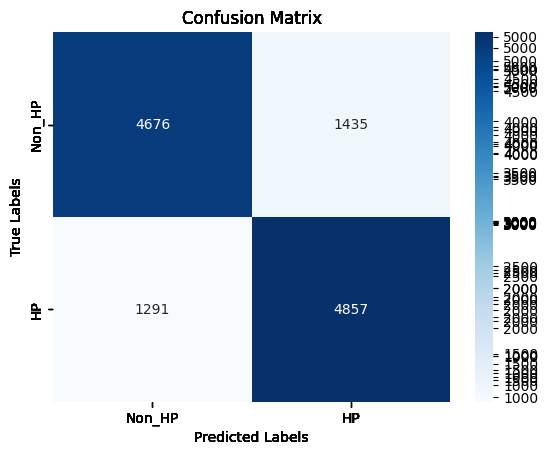

In [37]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [38]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [39]:
test_df = fine_tune_test_df

In [40]:
test_df

,text,label
1026,i have a replicaset with the primary running m...,1
1460,hi this is my first jira ticket so please forg...,1
1113,what problem are you facing i updated from v t...,1
707,introduced here after a network read error the...,1
857,hello compass allows transforming a document f...,0
...,...,...
1130,the secondaryreadspassthrough task on runs mon...,0
1294,engineering ticket descriptioni get better thr...,0
860,hi i have implemented the lab through mongo un...,1
1459,im not sure what the impact of this could be b...,0


In [41]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [42]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [43]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [44]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [45]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [46]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


Fold 1


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


Fold 2


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


In [47]:
deberta_predictions


[array([[0.4774991 , 0.52250093],
        [0.8803514 , 0.11964854],
        [0.44675422, 0.5532458 ],
        ...,
        [0.4581314 , 0.54186857],
        [0.62732834, 0.37267172],
        [0.52382416, 0.47617584]], dtype=float32),
 array([[0.18840426, 0.81159574],
        [0.95025665, 0.0497434 ],
        [0.46967238, 0.5303276 ],
        ...,
        [0.19069429, 0.80930567],
        [0.75577474, 0.24422532],
        [0.46859074, 0.5314092 ]], dtype=float32),
 array([[0.04715319, 0.9528468 ],
        [0.97349244, 0.02650753],
        [0.165821  , 0.834179  ],
        ...,
        [0.18634082, 0.8136592 ],
        [0.3418615 , 0.65813845],
        [0.29839432, 0.7016057 ]], dtype=float32)]

In [48]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.2376855 , 0.7623145 ],
       [0.9347002 , 0.06529982],
       [0.3607492 , 0.63925076],
       ...,
       [0.27838883, 0.7216112 ],
       [0.5749882 , 0.42501184],
       [0.43026972, 0.5697302 ]], dtype=float32)

In [49]:
len(predictions)

1272

In [50]:
predictions

array([[0.2376855 , 0.7623145 ],
       [0.9347002 , 0.06529982],
       [0.3607492 , 0.63925076],
       ...,
       [0.27838883, 0.7216112 ],
       [0.5749882 , 0.42501184],
       [0.43026972, 0.5697302 ]], dtype=float32)

In [51]:
test_df["prediction_0"] = predictions[:, 0] 

In [52]:
test_df["prediction_1"] = predictions[:, 1] 

In [53]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [54]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1026,i have a replicaset with the primary running m...,1,0.237686,0.762314,1,1,1
1460,hi this is my first jira ticket so please forg...,1,0.934700,0.065300,0,0,0
1113,what problem are you facing i updated from v t...,1,0.360749,0.639251,1,1,1
707,introduced here after a network read error the...,1,0.336851,0.663149,0,1,1
857,hello compass allows transforming a document f...,0,0.506730,0.493270,0,0,1
...,...,...,...,...,...,...,...
1130,the secondaryreadspassthrough task on runs mon...,0,0.503315,0.496685,0,0,1
1294,engineering ticket descriptioni get better thr...,0,0.940263,0.059737,0,0,0
860,hi i have implemented the lab through mongo un...,1,0.278389,0.721611,1,1,1
1459,im not sure what the impact of this could be b...,0,0.574988,0.425012,0,0,1


In [55]:
len(test_df)

1272

In [56]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [57]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [58]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [59]:
test_df["pred"] = test_df["pred"].astype(int)

In [60]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1026,i have a replicaset with the primary running m...,1,0.237686,0.762314,1,1,1,prediction_1,1
1460,hi this is my first jira ticket so please forg...,1,0.934700,0.065300,0,0,0,prediction_0,0
1113,what problem are you facing i updated from v t...,1,0.360749,0.639251,1,1,1,prediction_1,1
707,introduced here after a network read error the...,1,0.336851,0.663149,0,1,1,prediction_1,1
857,hello compass allows transforming a document f...,0,0.506730,0.493270,0,0,1,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1130,the secondaryreadspassthrough task on runs mon...,0,0.503315,0.496685,0,0,1,prediction_0,0
1294,engineering ticket descriptioni get better thr...,0,0.940263,0.059737,0,0,0,prediction_0,0
860,hi i have implemented the lab through mongo un...,1,0.278389,0.721611,1,1,1,prediction_1,1
1459,im not sure what the impact of this could be b...,0,0.574988,0.425012,0,0,1,prediction_0,0


In [61]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[360 280]
 [241 391]]


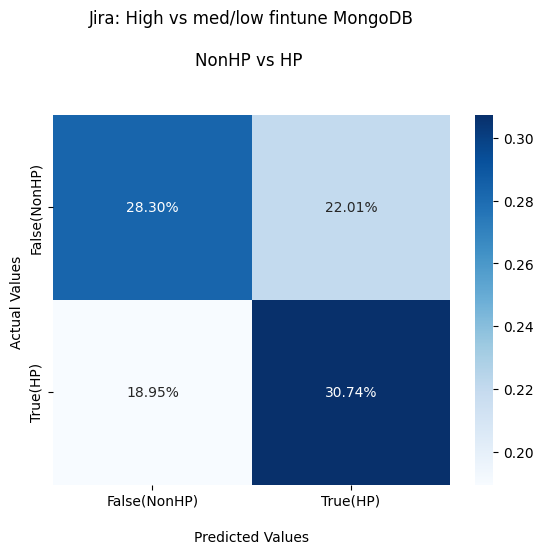

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title(f'Jira: High vs med/low fintune {project_name}\n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       640
           1       0.58      0.62      0.60       632

    accuracy                           0.59      1272
   macro avg       0.59      0.59      0.59      1272
weighted avg       0.59      0.59      0.59      1272



In [64]:
test_df[["text","label","pred"]].to_csv(f"{file_name}_70_Test_inference.csv")

In [65]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.18144225654467067


In [66]:
tracker.stop()

0.02344197129565683